In [1]:
!pip install -q diffusers transformers accelerate deep-translator
!pip install --upgrade peft
!pip install protobuf==3.20.3
!pip uninstall -y diffusers transformers accelerate peft
!pip install diffusers transformers accelerate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:0000:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.3 MB/s eta 0:00:00:00:0100:01m
ERROR: pip's dependency reso

In [2]:
import torch
import gc
from diffusers import StableDiffusionPipeline, StableDiffusionInstructPix2PixPipeline
from transformers import pipeline
from deep_translator import GoogleTranslator
from PIL import Image
from IPython.display import display 

device = "cuda" if torch.cuda.is_available() else "cpu"
to_english = GoogleTranslator(source='auto', target='en')
to_arabic = GoogleTranslator(source='en', target='ar')

def flush():
    gc.collect()
    torch.cuda.empty_cache()

2025-12-12 00:04:32.631869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765497872.960019      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765497873.058962      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.



 (Stable Diffusion)....


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

>> Write a description of the image you want:  لافتة مكتوب عليها "ممنوع ركن السيارات"


Drawing in progress: A sign reading "No parking" ...


  0%|          | 0/50 [00:00<?, ?it/s]


 The drawing is complete! This is your picture:


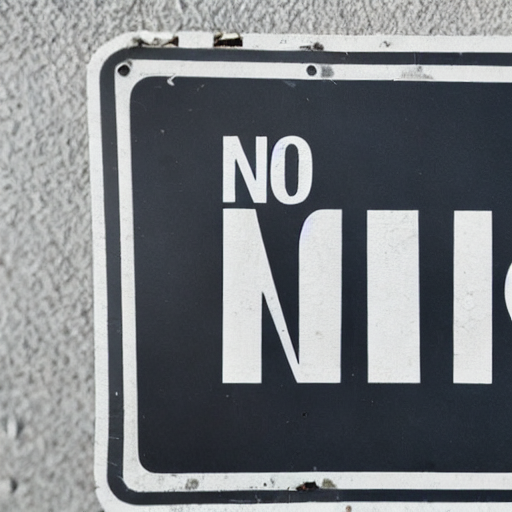

In [9]:

print("\n (Stable Diffusion)....")
pipe_gen = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    torch_dtype=torch.float16 if device=="cuda" else torch.float32
).to(device)

print("\n" + "="*40)
prompt_1 = input(">> Write a description of the image you want: ")
english_prompt_1 = to_english.translate(prompt_1)
print("="*40)

print(f"Drawing in progress: {english_prompt_1} ...")
image_original = pipe_gen(english_prompt_1).images[0]
image_original.save("original.png")


del pipe_gen
flush()

print("\n The drawing is complete! This is your picture:")
display(image_original) 

In [10]:

print("\n First image analysis is underway...")
caption_pipe = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device=0 if device=="cuda" else -1)
caption_1_en = caption_pipe(image_original)[0]['generated_text']
caption_1_ar = to_arabic.translate(caption_1_en)

print(f" (EN): {caption_1_en}")
print(f" (AR): {caption_1_ar}")


del caption_pipe
flush()



 First image analysis is underway...


Device set to use cuda:0


 (EN): a street sign with a black arrow pointing to the left 
 (AR): لافتة شارع بها سهم أسود يشير إلى اليسار


In [11]:


print("\n" + "="*40)
print("What do you want to change?")
prompt_2 = input(">> Write the modification (e.g., make it nighttime, add freshness): ")
english_prompt_2 = to_english.translate(prompt_2)
print("="*40)



What do you want to change?


>> Write the modification (e.g., make it nighttime, add freshness):  لافتة مكتوب عليها "ممنوع ركن السيارات" لافتة شارع بسماء زرقاء


In [12]:

print("\n✨ Loading the modifier (InstructPix2Pix)...")
pipe_edit = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32
).to(device)

print(f": {english_prompt_2} ...")
image_edited = pipe_edit(prompt=english_prompt_2, image=image_original, num_inference_steps=20, image_guidance_scale=1.2).images[0]
image_edited.save("edited.png")

del pipe_edit
flush()


✨ Loading the modifier (InstructPix2Pix)...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

: "No Parking" sign, street sign with blue sky ...


  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:

caption_pipe = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device=0 if device=="cuda" else -1)
caption_2_en = caption_pipe(image_edited)[0]['generated_text']
caption_2_ar = to_arabic.translate(caption_2_en)

del caption_pipe
flush()

Device set to use cuda:0



############################################################
(Final Report)
############################################################


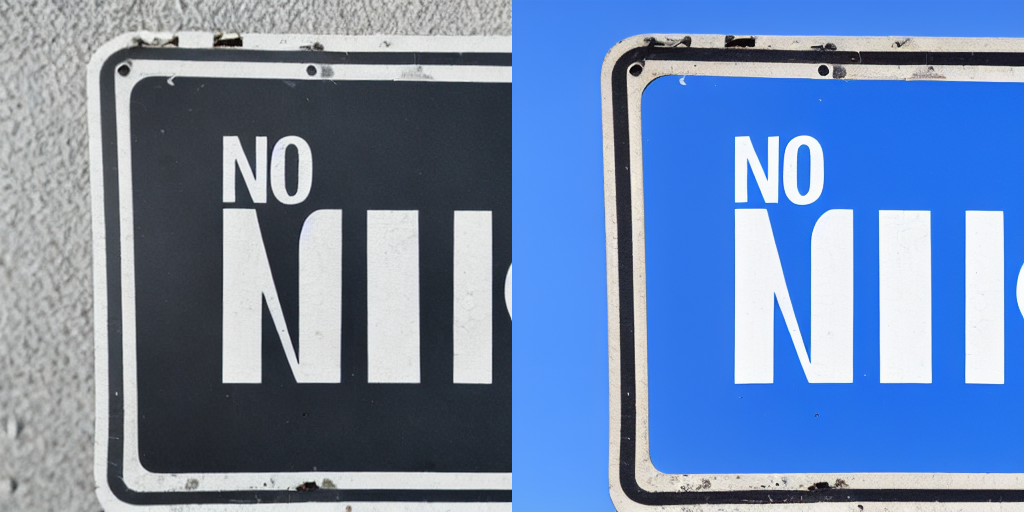


 Original image:
 : لافتة مكتوب عليها "ممنوع ركن السيارات"
 (AR): لافتة شارع بها سهم أسود يشير إلى اليسار
 (EN): a street sign with a black arrow pointing to the left 

 The edited image:
 : لافتة مكتوب عليها "ممنوع ركن السيارات" لافتة شارع بسماء زرقاء
 (AR): لافتة شارع بسماء زرقاء
 (EN): a street sign with a blue sky 


In [14]:

print("\n" + "#"*60)
print("(Final Report)")
print("#"*60)


total_width = image_original.width * 2
combined_view = Image.new('RGB', (total_width, image_original.height))
combined_view.paste(image_original, (0, 0))
combined_view.paste(image_edited, (image_original.width, 0))

display(combined_view)

print("\n Original image:")
print(f" : {prompt_1}")
print(f" (AR): {caption_1_ar}")
print(f" (EN): {caption_1_en}")

print("\n The edited image:")
print(f" : {prompt_2}")
print(f" (AR): {caption_2_ar}")
print(f" (EN): {caption_2_en}")